In [35]:
# !pip install tqdm matplotlib numpy captum scikit-learn pretrainedmodels

In [4]:
# !pip install kaggle
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [5]:
# # !pip install zipfile36
# with zipfile.ZipFile("chest-xray-pneumonia.zip","r") as zip_ref:
#     zip_ref.extractall("chest_xray")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


from tqdm import tqdm

In [5]:
data_dir = './xray_dataset/'
# convert all input images to square tensors
# this step is probably ruining the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4),
    # transforms.ColorJitter(brightness=0.3),
    # transforms.RandomRotation(15),
    # normalize the data
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize((0.5,), (0.5,)),
])


In [6]:
# Load training data
train_data = ImageFolder(root=data_dir + 'train', transform=transform)

# Load validation data
val_data = ImageFolder(root=data_dir + 'val', transform=transform)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=8)

# Load test data
test_data = ImageFolder(root=data_dir + 'test', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=8)

### Data loaders

In [7]:
# from torch.utils.data import DataLoader, TensorDataset

# # Create TensorDataset objects
# train_dataset = TensorDataset(train_data, train_labels)
# val_dataset = TensorDataset(val_data, val_labels)
# test_dataset = TensorDataset(test_data, test_labels)

# # Create DataLoader objects
batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Let's do some displaying

### Let's do some training

In [8]:
from torch.utils.data import DataLoader, WeightedRandomSampler

# Calculate class weights
class_counts = [0] * len(train_data.classes)
print(class_counts)
labels_ = [label for _, label in tqdm(train_data)]
for label in tqdm(labels_):
    class_counts[label] += 1
class_weights = [1.0 / count for count in class_counts]
sample_weights = [class_weights[label] for label in labels_]


# Create weighted sampler and data loader
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

[0, 0]


100%|██████████| 5216/5216 [00:00<00:00, 2810571.64it/s]


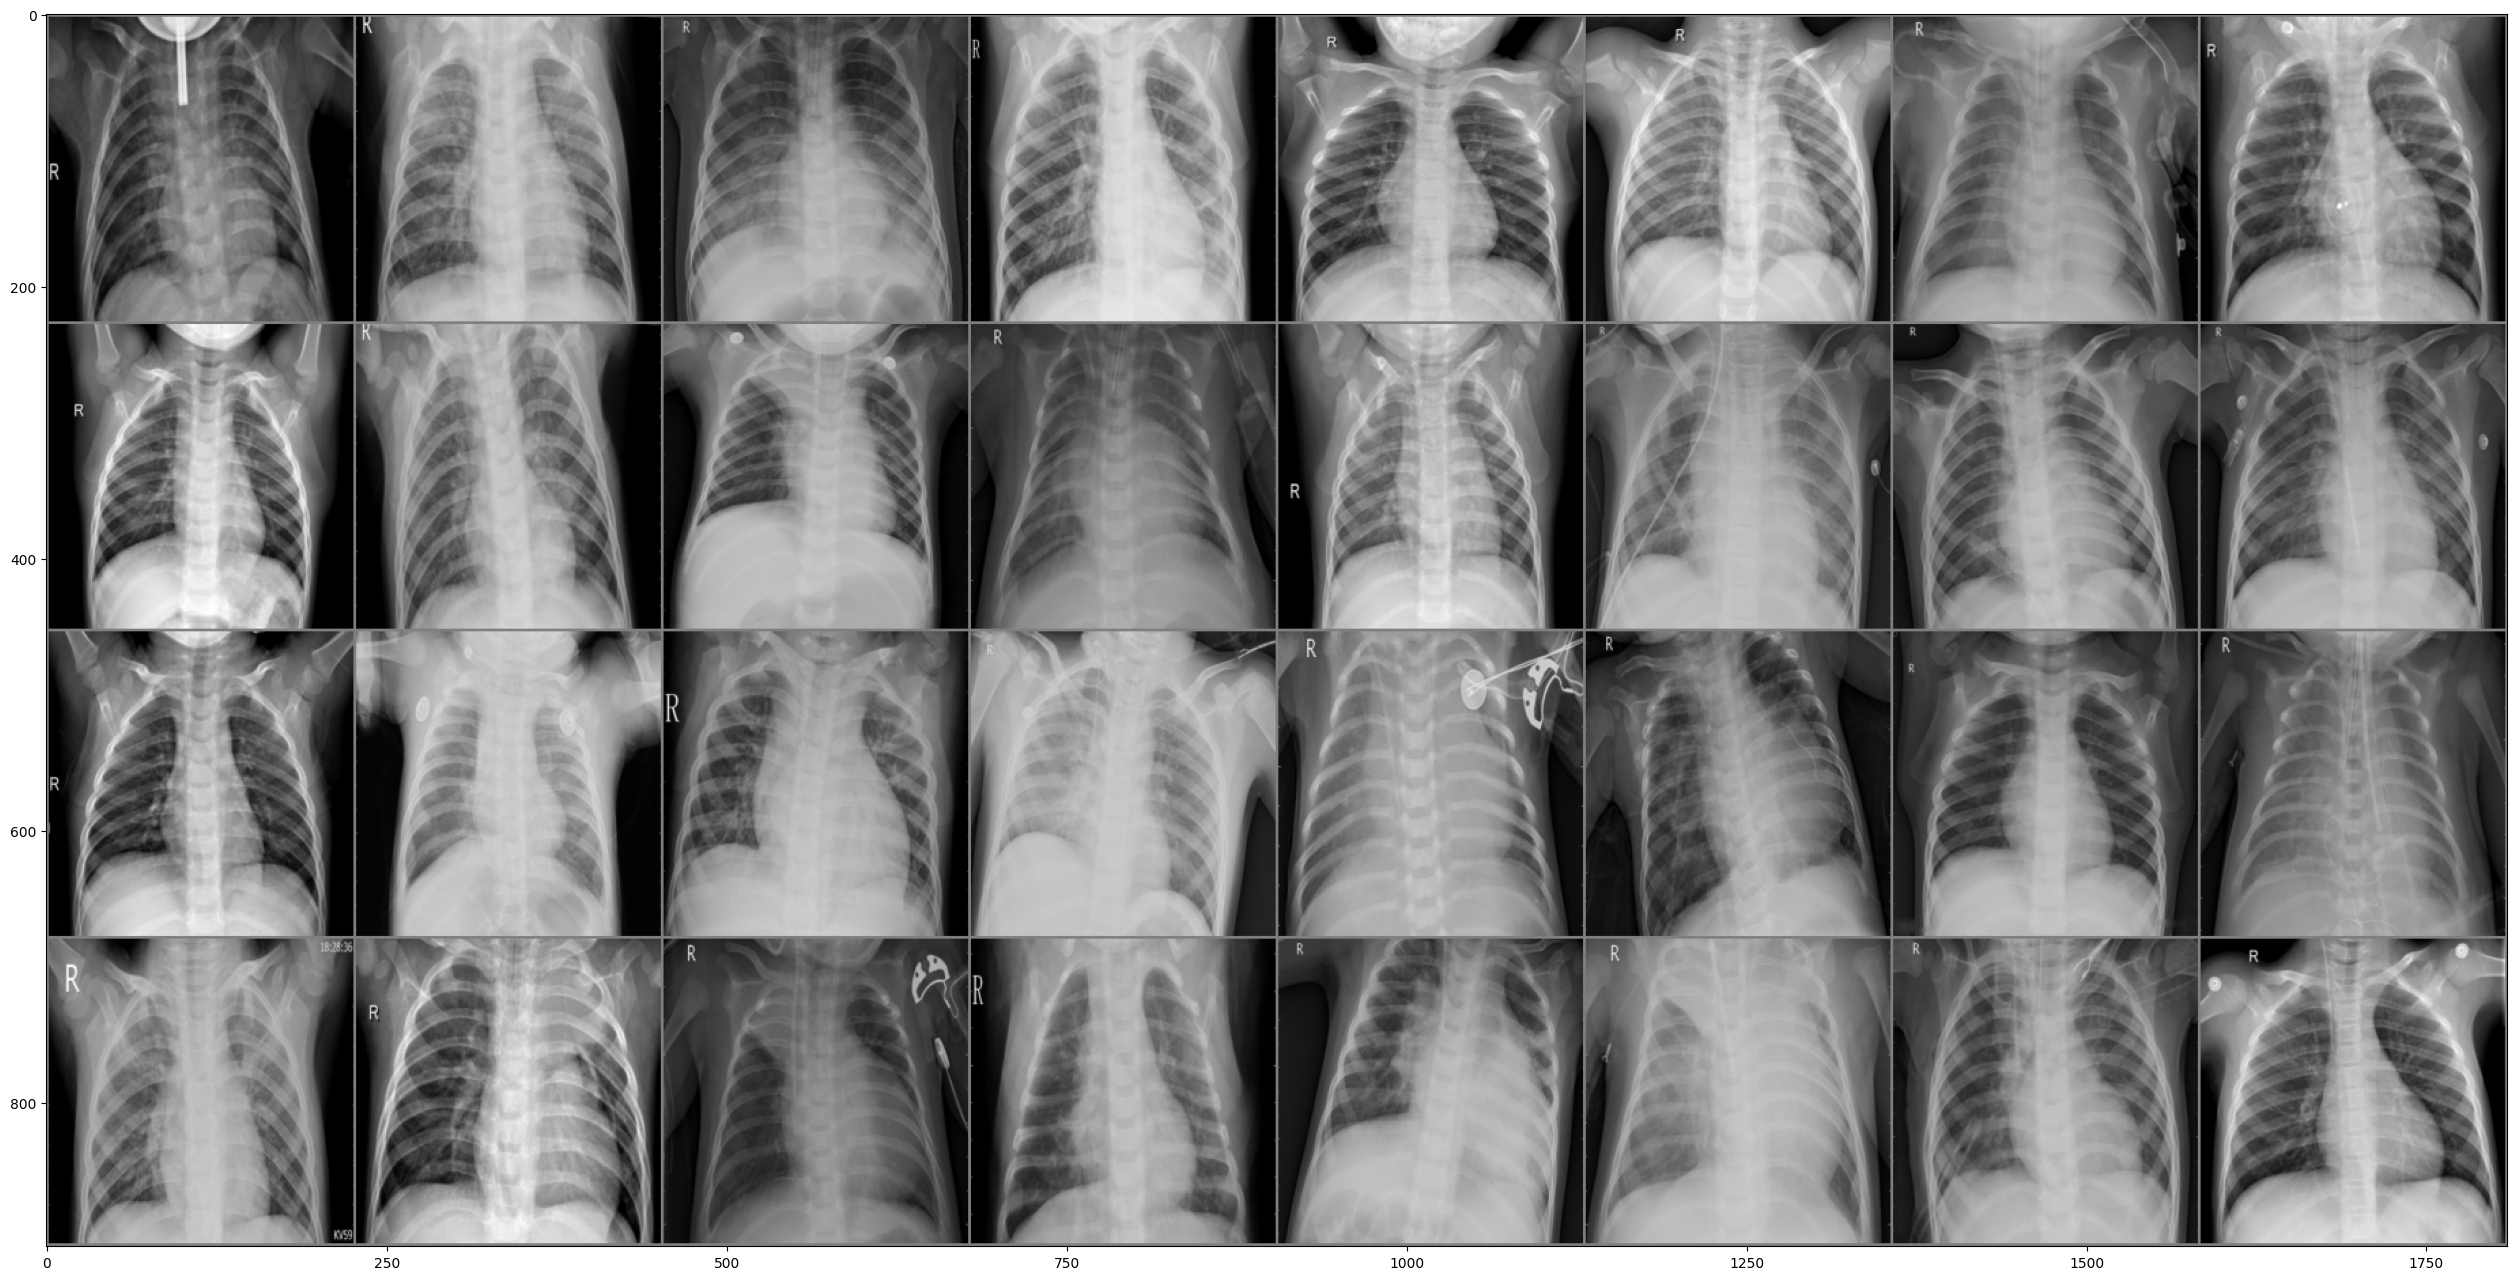

[[1 1 1 1 0 0 1 1]
 [0 1 1 1 0 1 1 1]
 [0 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 0]]


In [46]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(32, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('images.pdf')
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

labels = np.array([labels[j] for j in range(32)]).reshape((4,8))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [32]:
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import logging

logging.basicConfig(filename='logs.log', level=logging.INFO)

import torchvision.models as models


model = models.resnet18(pretrained=True)

# Modify first layer to accept 3-channel input (RGB)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify last linear layer to output 2 classes
model.fc = nn.Sequential(
    nn.BatchNorm1d(512),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=512, out_features=256),
    nn.ReLU(),
    nn.BatchNorm1d(256, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=256, out_features=64),
    nn.ReLU(),
    nn.BatchNorm1d(64, eps=1e-05, momentum=0.1),
    nn.Dropout(p=0.2),
    nn.Linear(in_features=64, out_features=2),
)

# Use AdaptiveAvgPool2d to allow for variable input image sizes
model.avgpool = nn.AdaptiveAvgPool2d((1, 1))


device = 'cuda'
net = model.to(device)


criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))


optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [34]:
EPOCHS = 20
PRINT_EVERY = 1000

for epoch in range(EPOCHS):
      
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # move inputs and labels to MPS device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    scheduler.step()


print('Finished Training')

100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 0: 0.444, test_acc: 85.26%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 1: 0.667, test_acc: 84.13%


100%|██████████| 163/163 [01:45<00:00,  1.55it/s]


Test set loss for EPOCH 2: 0.534, test_acc: 85.74%


100%|██████████| 163/163 [01:44<00:00,  1.55it/s]


Test set loss for EPOCH 3: 0.653, test_acc: 84.13%


100%|██████████| 163/163 [01:44<00:00,  1.55it/s]


Test set loss for EPOCH 4: 0.507, test_acc: 87.98%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 5: 0.745, test_acc: 84.29%


100%|██████████| 163/163 [01:44<00:00,  1.55it/s]


Test set loss for EPOCH 6: 0.559, test_acc: 88.94%


100%|██████████| 163/163 [01:44<00:00,  1.55it/s]


Test set loss for EPOCH 7: 0.652, test_acc: 88.14%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 8: 0.649, test_acc: 86.22%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 9: 0.592, test_acc: 86.54%


100%|██████████| 163/163 [01:45<00:00,  1.55it/s]


Test set loss for EPOCH 10: 0.567, test_acc: 88.94%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 11: 0.632, test_acc: 88.46%


100%|██████████| 163/163 [01:44<00:00,  1.55it/s]


Test set loss for EPOCH 12: 0.762, test_acc: 86.22%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 13: 0.741, test_acc: 87.82%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 14: 0.843, test_acc: 86.38%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 15: 0.741, test_acc: 87.98%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 16: 0.799, test_acc: 86.86%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 17: 0.838, test_acc: 87.50%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 18: 0.828, test_acc: 87.82%


100%|██████████| 163/163 [01:44<00:00,  1.56it/s]


Test set loss for EPOCH 19: 0.859, test_acc: 88.94%
Finished Training


In [35]:
# # save the model
# MODEL_PATH = './xray_net.pth'
# torch.save(net.state_dict(), MODEL_PATH)


In [36]:
print(f'Test set loss: {test_loss:.3f}, test_acc: {test_acc:.2f}%')

Test set loss: 0.859, test_acc: 88.94%
